# Introduction
With the world becoming increasingly urbanised, natural habitats, which have remained pristine for millions of years, are shrinking rapidly. Particularly, birds are threated due to the severe loss of their habitat and open space, leading to the extinction of hundreds of species. However, as science advances, new technology is being developed in order to help combat this. In this notebook, I will be creating a neural network using transfer learning based on [Resnet50](https://keras.io/api/applications/resnet/#resnet50-function) (a model specialising in image classification), to create a neural network that can classify birds based on images into 475 different species (using [this dataset](https://www.kaggle.com/datasets/gpiosenka/100-bird-species)) in order to help scientists and activists combat the extinction of avian species using image recognition technology. This dataset is extremely large, with 75000+ training images and 2000+ validation images, so I will be using a GPU to speed things up. I originally planned to use a Tensor Processing Unit (TPU), which is specially designed for running neural networks. However, this didn't go very well, but I'll get into that at the end.

## Importing Packages and Other Useful Things
In this section, I will be importing useful packages and my GPU, which will all be used throughout this project. More detail in the comments.

In [1]:
import tensorflow as tf #Imports tensorflow, used for neural network building
from tensorflow.compat.v1.keras.applications.resnet50 import preprocess_input
from tensorflow.compat.v1.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt #Imports pyplot, used for plotting graphs
import matplotlib.image as mpimg #Imports matplotlib.image, used for images
import glob #Used for image paths
import pathlib #used for image paths
import pandas as pd #used for data frames

# #This code is for implementing my GPU
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
except ValueError:
    tpu = None
    gpus = tf.config.experimental.list_physical_devices('GPU')

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    print("Running on TPU: " + str(tpu.master()))
elif len(gpus) > 0:
    # strategy = tf.distribute.MirroredStrategy(gpus)
    print("Running on ",len(gpus)," GPU(s)")
else:
    strategy = tf.distribute.get_strategy()
    print("Running on CPU")

# print(tf.config.list_physical_devices('GPU'))


2023-05-06 01:29:31.275189: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-06 01:29:33.730524: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Running on  1  GPU(s)


2023-05-06 01:29:37.547781: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-06 01:29:37.757887: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-06 01:29:37.758206: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

## Model Creation
In this section, I will create my model via transfer learning using ResNet50. To do this, I will import the ResNet50 model and essentially chop off the top layer and add my own layer, allowing me to customise the model to fit my specific purpose. The reason why I can use ResNet50 instead of building my own entire neural network from scratch is that ResNet is specially trained for image classification, being trained on over one million images. The commented out line of code below is a remnant from when I tried to add a TPU to speed up the model training, but it didn't work out, which I will get to later.

In [15]:
num_classes = 525
# resnet_weights_path = '../input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
#with tpu_strategy.scope():
my_new_model = tf.keras.Sequential([
    tf.keras.applications.ResNet50(include_top=False,input_shape=(224,224,3),pooling='avg'),
    tf.keras.layers.Dense(num_classes,activation='softmax')
    ])

my_new_model.layers[0].trainable = False
my_new_model.summary()
my_new_model.compile(
    loss= tf.keras.losses.CategoricalCrossentropy(),
    optimizer= tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics= ['accuracy']
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_1 (Dense)             (None, 525)               1075725   
                                                                 
Total params: 24,663,437
Trainable params: 1,075,725
Non-trainable params: 23,587,712
_________________________________________________________________


# Loading Data
Now, I need to load the data from the dataset. Luckily, the dataset I am using already has a training folder and a validation folder set up, each with respective images. Due to the high number of images (75000+ training, 2000+ validation), the batch size (the number of samples passed through the network in one iteration) is set to 256, a really high number.

In [3]:

def make_train_generator():
    
    train_generator = image_dataset_from_directory("archive/train",image_size=(224, 224), label_mode='categorical', batch_size=32)
    train_generator = train_generator.map(lambda x, y: (tf.image.resize(x, (224, 224)), y))
    train_generator = train_generator.batch(32)
    train_generator = train_generator.prefetch(1)
    return train_generator

def make_validation_generator():
    
    validation_generator = image_dataset_from_directory("archive/valid",image_size=(224, 224), label_mode='categorical', batch_size=32)
    validation_generator = validation_generator.map(lambda x, y: (tf.image.resize(x, (224, 224)), y))
    validation_generator = validation_generator.batch(32)
    validation_generator = validation_generator.prefetch(1)

    return validation_generator


train_dataset = tf.data.Dataset.from_generator(make_train_generator,(tf.float32, tf.float32))
validation_dataset = tf.data.Dataset.from_generator(make_validation_generator,(tf.float32, tf.float32))

In [13]:
image_size = 224
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)


train_generator = data_generator.flow_from_directory(
        'archive/train/',
        target_size=(image_size, image_size),
        batch_size=32,
        class_mode='categorical')

validation_generator = data_generator.flow_from_directory(
        'archive/valid/',
        target_size=(image_size, image_size),
        batch_size=32,
        class_mode='categorical')

Found 84635 images belonging to 525 classes.
Found 2625 images belonging to 525 classes.


## Data Visualisation
Before I get into fitting my model, I want to visualise my data first. Data visualisation isn't 100% necessary, but it allows us to get a good grasp on the data we are working with, which is always helpful.

### Setting Up Random Images
First, I'll create a function that can get random images from the data.

In [5]:
import os
train = "archive/train/"
valid = "archive/valid/"
def process(data):
    path=pathlib.Path(data)#converting the dtring to path
    filepaths=list(path.glob(r"*/*.jpg"))#Going through all the subpaths 
    labels=list(map(lambda x: os.path.split(os.path.split(x)[0])[1],filepaths))#Separating the label from filepath and storing it
    df1=pd.Series(filepaths,name='filepaths').astype(str)
    df2=pd.Series(labels,name='labels')
    df=pd.concat([df1,df2],axis=1)#Making the dataframe
    return df
df_train = process(train)
df_valid = process(valid)

### Visualise

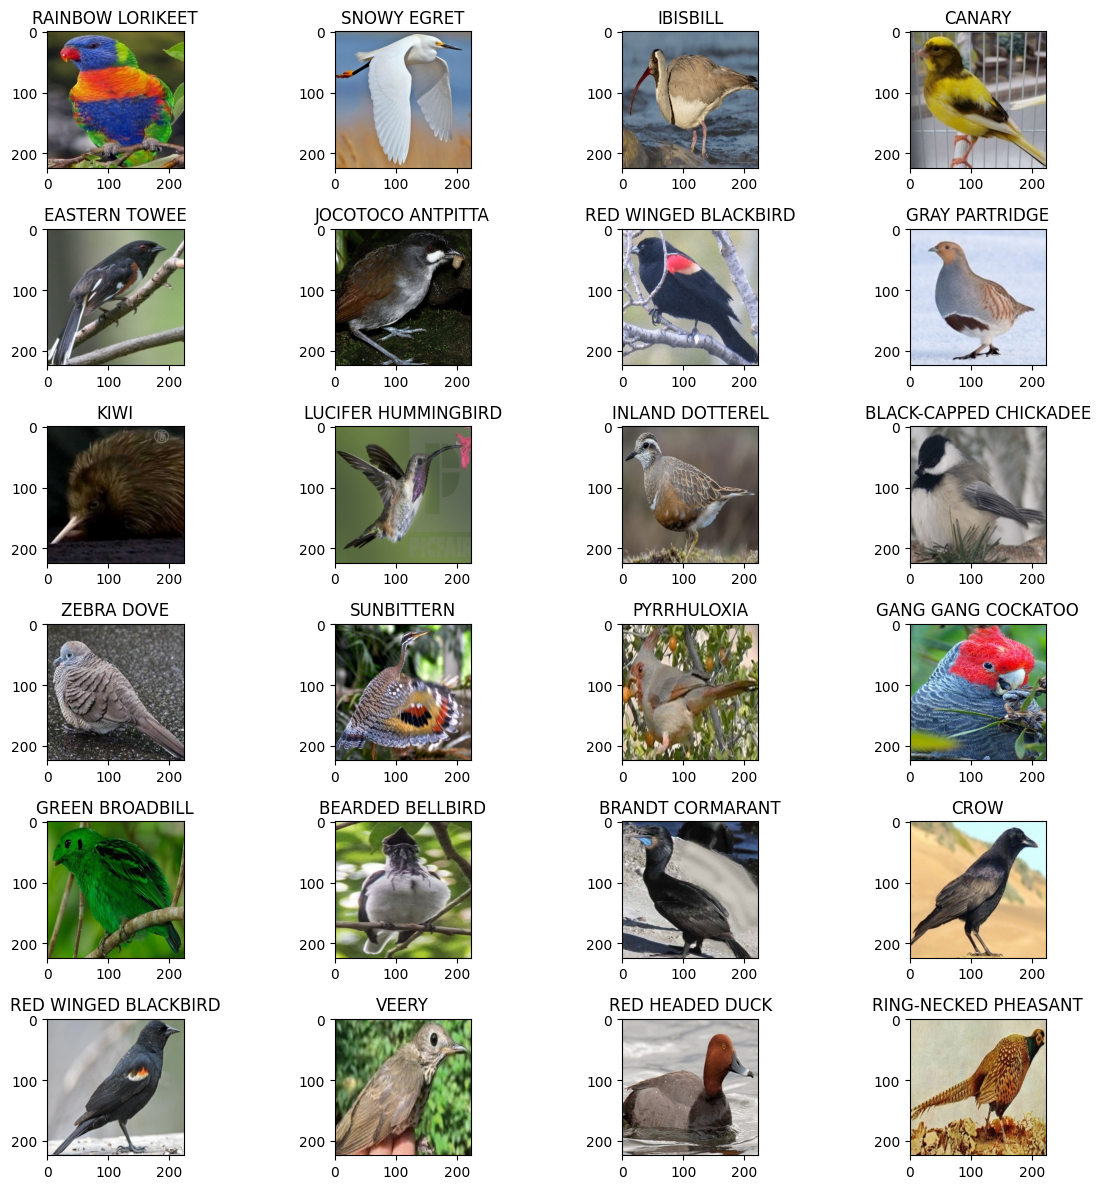

In [6]:
df_train=df_train.sample(frac=1).reset_index(drop=True)#Shuffling the dataframe so we can get random bird pictures
fig,axes=plt.subplots(nrows=6,ncols=4,figsize=(12,12))

for i,ax in enumerate(axes.flat):
    x=plt.imread(df_train['filepaths'][i])#reading the image
    ax.imshow(x)
    ax.set_title(df_train['labels'][i])
plt.tight_layout()    
plt.show()   

Wow! Look at those beautiful birds! I think data visualisation is a great addition to the notebook. Not only does it allow both me and the reader to see the kinds of images being used, but also it makes the notebook more visually appealing. Anyway, let's finally get to fitting the model.

## Model Fitting
In this section, I am fitting the model. I've set the epochs, which are the number of cycles all of the training data is run through in its entirety, to 10, which is a pretty standard number. Generally speaking, the more epochs you have, the more accurate your model is going to be, but that isn't always the case. Also, more epochs means your model takes more time to run, which has its own downsides. Model efficiency has been a huge struggle throughout this project, but I'll get to that later.

In [16]:
history = my_new_model.fit(train_generator, epochs= 1, validation_data=validation_generator) 

2023-05-06 01:32:30.002732: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-06 01:32:34.610147: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-05-06 01:32:38.508485: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x560d4a439b20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-06 01:32:38.508516: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): Quadro M1200, Compute Capability 5.0
2023-05-06 01:32:38.551238: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


   1/2645 [..............................] - ETA: 6:40:04 - loss: 6.8615 - accuracy: 0.0000e+00

2023-05-06 01:32:38.932116: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2645/2645 [==============================] - ETA: 0s - loss: 1.1010 - accuracy: 0.7576

2023-05-06 01:56:35.170566: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


2645/2645 [==============================] - 1487s 559ms/step - loss: 1.1010 - accuracy: 0.7576 - val_loss: 0.3937 - val_accuracy: 0.8930


In [17]:
my_new_model.save('model.h5')

: 

## Accuracy Visualisation
Wow! This model is really, really, really accurate with a score of 99% after 10 epochs. Let's visualise the accuracy and validation accuracy using some graphs.

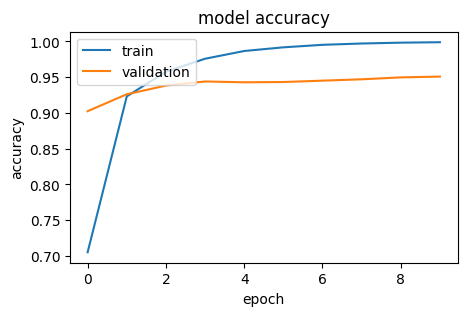

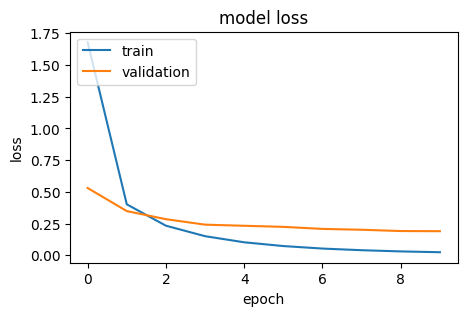

In [17]:
plt.rcParams["figure.figsize"] = (5,3)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Conclusion
My model has a 99% accuracy after 10 epochs. This is really good, but there is still much to be discussed. One notable finding from this project is the power of transfer learning. Without using ResNet50, achieving an accuracy of 99% in such a short timeframe (a couple of weeks) would've been impossible. By using a stellar pretrained base like ResNet50 that specialises in image classification, I am able to easily get a neural network that suits my needs just by customising it a little. Another notable finding is how GPUs (and TPUs) are almost imperative when running neural networks with so much training data like mine. If it wasn't for the GPU, I would've spent over an hour running my project, making working highly inefficient. Having a GPU/TPU made working on this project so much easier. 
## Challenges
Throughout this project, I have come across many, many challenges. Firstly, the dataset that I chose is massive. When I initially ran my neural network, it took over an hour to complete 10 epochs. This made it extremely difficult to work on my project because after every edit I made, I would have to wait an hour to see if I obtained my desired outcome. This leads directly into my next problem: installing a TPU. To speed up my neural network, I wanted to add a TPU. However, this proved to be extremely challenging. Since this is my first project involving neural networks, I had never used a TPU (or a GPU for that matter) before. When I looked up how to use it, I came across numerous projects that all implemented their TPUs differently. This was extremely confusing and I spent a lot of time trying different methods of implementing the TPU. Eventually, after many, many failures and the project deadline fast approaching, I gave up on adding the TPU and settled for the GPU. Although the GPU is fast and has significantly reduced runtime, it still isn't at a speed that I can truly deem "efficient".
## Future Work
With all the challenges I encountered, there were a few things I was unable to do for this project but am still looking to do in the future. Firstly, I wasn't able to do data augmentation. Data augmentation is a technique used to improve the accuracy of a model by introducing additional data that is related to the original data set. By taking images from the dataset and altering them through means such as but not limited to warping, changing colours, and flipping, we can create additional data for the model to be trained on. This extra data is also vastly different than the data we already have, so by increasing the array of images we are feeding our neural network, we often see an increase in accuracy. Although my model is already 99% accurate, exploring data augmentation could've still been a worthwhile venture and is something I am looking forward to doing in a later project. A second area for future work is adding a TPU. As previously mentioned, I wasn't able to get a TPU working for this project. However, knowing how fast TPUs are, implementing one in a future project would make working much more efficient since I wouldn't have to wait for as long to get my results. A third area for future work is adding more data for female birds. In the dataset, there was a disproportionate number of images of male birds. This is because in most bird species, male birds tend to be more colourful than their female counterparts so that they can attract mates. As a result of this, female birds across multiple species may share similar colour patterns of dreary brown, grey, and black. This makes it much harder for my model to classify a female bird, since they are visually less distinct. Thus, perhaps in a future iteration of this notebook, I can add data containing other factors that can distinguish bird species, such as beak type, wing shape, etc.
## Closing Statement
All in all, I hope that this project can be utilised by scientists and activists alike to identify and classify birds they encounter to keep track of populations and combat exctinction. Outside of academic usage, I hope that this project will be equally useful to people such as avian enthusiasts, who can use this project to identify and document bird sightings.